<a href="https://colab.research.google.com/github/mobarakol/Surgical_Instruments_Segmentation/blob/master/Demo_Instrument_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the repository

In [1]:
!git clone https://github.com/mobarakol/Surgical_Instruments_Segmentation.git
%cd Surgical_Instruments_Segmentation

Cloning into 'Surgical_Instruments_Segmentation'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), 2.69 MiB | 1.64 MiB/s, done.
/content/Surgical_Instruments_Segmentation


Download trained weights and valid set

In [2]:
# https://drive.google.com/file/d/10s1NQhbJsEUDsrax7MvQWQUwOwSucsDi/view
import gdown
import os

url = 'https://drive.google.com/uc?id=10s1NQhbJsEUDsrax7MvQWQUwOwSucsDi'
gdown.download(url,'epoch_76.pth.tar',quiet=True) 

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ids = ['1Q45JutY3Fu4wqf4z_Xarz6CTJnyofnSx']
zip_files = ['instrument17_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file

Datalaoder

In [3]:
from PIL import Image
import random
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class instruDataset(Dataset):
    def __init__(self, img_dir, is_train=None):
        self.is_train = is_train
        self.img_anno_pairs = img_dir

    def __len__(self):
        return len(self.img_anno_pairs)

    def __getitem__(self, index):
        _img = Image.open(self.img_anno_pairs[index]).convert('RGB')
        _tar_path = self.img_anno_pairs[index].replace('images', 'instruments_masks')[:-3] + 'png'
        _target = Image.open(_tar_path)
        if self.is_train:
            hflip = random.random() < 0.5
            if hflip:
                _img = _img.transpose(Image.FLIP_LEFT_RIGHT)
                _target = _target.transpose(Image.FLIP_LEFT_RIGHT)

        _img = torch.from_numpy(np.array(_img).transpose(2,0,1)).float()
        _target_main = torch.from_numpy(np.array(_target)).long()
        _target_aux = _target.resize((160, 128), Image.NEAREST)
        _target_aux = torch.from_numpy(np.array(_target_aux)).long()
        return _img, _target_main, _target_aux

Evaluation:

In [38]:
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch
from model import InstrumentsMFF
from glob import glob
import numpy as np
import sys
import os
import random
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def validate(valid_loader, model, num_classes=8):
    if not os.path.exists('true_seg'): os.makedirs('true_seg')
    if not os.path.exists('pred_seg'): os.makedirs('pred_seg')
    confusion_matrix = np.zeros(
            (num_classes, num_classes), dtype=np.uint32)
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels_seg,_) in enumerate(valid_loader):
            inputs, labels_seg = inputs.to(device), np.array(labels_seg)
            pred_seg = model(inputs)
            pred_seg = pred_seg.data.max(1)[1].squeeze_(1).cpu().numpy()
            confusion_matrix += calculate_confusion_matrix_from_arrays(
                pred_seg, labels_seg, num_classes)
            
    confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
    dices = {'dice_{}'.format(cls + 1): dice
                for cls, dice in enumerate(calculate_dice(confusion_matrix))}
    dices_per_class = np.array(list(dices.values()))          

    return dices_per_class

data_root_dir = 'instrument17_valid/**/images/'
img_dir = glob(data_root_dir + '*.jpg')
valid_dataset = instruDataset(img_dir=img_dir, is_train=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, shuffle=False, num_workers=2)
model = InstrumentsMFF(n_classes=8)
model = torch.nn.parallel.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load('epoch_76.pth.tar')) # test on final trained model
model.eval();

dices_per_class = validate(valid_loader, model, num_classes=8)
print('dice per class (ignore non-existing classes while calculating mean dice in the paper):', dices_per_class)

dice per class (ignore non-existing classes while calculating means dice in the paper): [6.33818110e-01 0.00000000e+00 0.00000000e+00 4.82921715e-01
 6.08857522e-06 6.02769824e-01 0.00000000e+00]


Visualization:

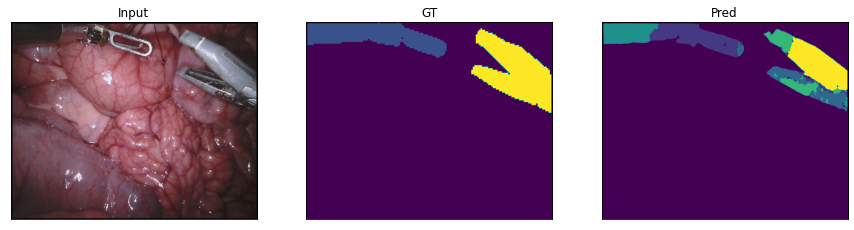

In [64]:
import matplotlib.pyplot as plt
from PIL import Image

img_num = 6
inputs, labels_seg = valid_dataset[img_num][0].to(device), np.array(valid_dataset[img_num][2])
pred_seg = model(inputs[None])
pred_seg = pred_seg.data.max(1)[1].squeeze_(1).cpu().numpy()

img = Image.open(img_dir[img_num])
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(img)
ax[0].set_title('Input')
ax[1].imshow(labels_seg)
ax[1].set_title('GT')
ax[2].imshow(pred_seg[0])
ax[2].set_title('Pred');